# Executive Summary 
(Business Audience)

## Objective
We were given a set of news articles and aim a identify efficient and sophisticated way to find words which are trending. To accomplish this we need to both
- Find trends within the sample dataset provided
- Demonstrate how the approach can be applied & scaled to larger datasets

## Data
- Covers ca 8000 news messages over 3 days in 16 Languages 
- After removing duplicate news and test and system messages, the remaining news are about only 1100 unique English articles

## Approach, Assumptions, Limitations
### Defining 'trending words'
Exceptional increase of mentions of a word or sequence of words in a consistent context. Main characteristics are:
- exceptional increase of mentions with respect to the overall mentions of the word AND
- some level of consistent context for those mentions



## Results
### Trending words found in the data

### Approach to trending developed
As the data is inherently unsupervised, we have built a model that can use statistical metrics for stationarity and topic homogeneity and does not rely on training data. However, we have labaled a small dataset for evaluaton purposes

================================= END EXECUTIVE SUMMARY =================================

## Technical Summary
(Technical i.e. Data Science Audience)

### Summary of evaluation approach
Aim is to show time series with trending words or word-ngrams. We interpret this as follows:
 1. high internal similarity (ie fairly homogeneous group of items, ie topic-like behavior) t-test on signifant difference in cosine similarity 
 2. exhibit non-stationarity (ie there is a marked change in behavior for those words - dickey fuller test on stationarity
 
To evaluate the results, there is no actual ground truth, the approach is tested against a small number of manually labelled ground truth of 
- top 50 most frequent words in the whole dataset (total count)
- top 30 highest spiking words in the dataset (highest mentions within a 2hr rolling period)

### High level description of pipeline
- Preprocessing: Some clean up done based on EDA (see steps on pre-processing below)
- Transformation: In order to identify trends, have considered basic counts, tf-idf and bucketed into 5min time_intervals for consistent time
- Evaluation:
    - Tests for internal similarity of a trending word: t-test performed between the overall cosine similary of all article pairs in the data vs all articles where the word is mention in their title
    - Tests for stationarity: Augmented Dickey Fuller test, tests whether there are momentum like trends in the series (ie unit roots) tests applied on a rolling time series of titlle mentions, either via TfIdf, Counts



## Detail on pipeline steps
|#|Stage|Step|Description|Outcome|Alternatives Considered|Relevant code|
|---|---|----|-----------|-------|-----------------------|-------------|
|1|Preprocessing|Remove by starting text|Articles starting with "Top news" are summaries so will distort trend statistics. Articles starting with "Test" are admin| 1010 articles removed | - | rm_rows_starting|
|2|Preprocessing|Remove by type of event|Event type "delete" removed, Story type "D" are service alerts and notify status of feed, hence both noth relevant | 1120 articles removed | - | rm_values_by_flag|
|3|Preprocessing|Merge Article Body| ACCUMULATED_STORY_TEXT & TAKE_TEXT seem to be mutually completing so merged and separete fields were dropped, minor clean up done | - | - | mrg_cols, clean_txt|
|4|Preprocessing|Group by unique ID| PNAC field provides unique IDs for all articles | ca 3600 duplicates removed, ca 2600 remain | Use 'Unique_story_index' however both approaches roughly halve the article population |group_by_id|
|5|Preprocessing|Restict to English| Use only English language articles. While a significant number of articles is dropped, the actual impact is negligible as most languages have very few articles - 16 languages have as many as English alone | ca 1200 duplicates remain | Using all languages, however, results should be independent of language and English lends itself to easier interpretation |-|
|6|Modelling|Clean up| Some removal of punctuation,etc | - | - |-|
|7|Modelling|Word vectorization| Tokenization and use of TfIdf of simple counts to formulate word time series | - | 1. NER can help remove some of the obviously repetitive and generic words & mentions of numbers \n 2. Lemmatisation can help aggregate similar words \n 3. Word/Sentence Embeddings for finer semantic attribution |build_time_series, Vectorizer, spacy_tokenizer|
|8|Modelling|Interval bucketing| Results bucketed further into 5min minute interval for consistent time units. Aggregation can be done either as a max or a sum frequency, where sum is prefered for counts and amx for TfIdf | - | Different time periods can be experimented with for optimal results |build_time_series, TimeBuckets|
|9|Prediction|Prediction| Positive labels are given to words which cannot reject the Dickey Fuller Test of Unit root and reject a T-test of similar correlation distributions | - | Can convert the predictor to a rolling value and predict "trending" flag as a function of both word and timepoint |pipe_predict|
|10|Evaluation|Accuracy| Measure accuracy aganst a small number of hand labeled values from the most frequent words used | - | Trends as a function of time would require more granular hand labelling to retain the ability to quantify performance of each setup |||



## Discussion of choices
### The Dickey Fuller test 
- The benefit of using the test is that it gives a statistical metric for aut
- The null hypothesis there is the presence of a unit root, ie each event influences the next one. However, here we are performing the test on rolling sums of wrod mentions. Therefore the accuracy of the test is somewhat impaired. The rolling sums approach is used as in most cases the data is extremely inoisy without some level of smoothing
- Some alternatives to the Dickey-Fuller test that can be appropriate here are 
     - the Chow test for structural breaks. However, it requires a known point where the break might be happening
     - T-test between distributions, eg long term distribtion vs some rolling distribution. However, it requires normal distributions of the underlyings while those are Poisson distributed here
     
### The T-test use for correlation distributions. 
- Helpful as provides a statistical metric
- Concerns around the assumption of normality of the underlying. Oftern correlation distributions exhibit beta distribution which makes the test potentially invalid
    
### On Embeddings and Transformer architectures (eg BERT)
There is still a lot of use that can be had from these. For instance:
- Word level embeddings can help find semantically meaningful trends. They can be used to find words with high cosine similarity (ie >95%) to identify synonyms and essentially equivalent words to improve the quality of aggregated individual words, eg cases like "America", "USA" , "the US" , etc will collase into one instance and help significantly in finding trends without using explainability
- Sentence level embeddings via eg BERT can be used to assess how homogeneous are collections of articles assigned to a trend. Similar to the solution here where cosine similarity of tf-idf on article bodies is leveraged, one can use sentence level embeddings for artcile titles and compare those instead or as a reinforcing indicator
- Sentence level embeddings can be used to stop article title duplication. Again, by observing high cosine similarity
- One shortcoming of sentence level embeddings could be some loss of interpretability. If used to build classifiers for trends (eg based on some weak supervision or small number of hand labeled examples) explainability might be lost in the inability to assign the sentence to a specific word which triggered the label

In [1]:
%load_ext autoreload

In [3]:
%matplotlib inline
import pandas as pd

%autoreload 2
import source.preprocess as pp
import source.modelling as md
import source.evaluation as ev

### Read in data

In [4]:
df=pd.read_csv('./raw_data/rna002_RTRS_2017_11_29.csv',engine='python', encoding='utf-8',error_bad_lines=False).fillna('')

Skipping line 8132: unexpected end of data


### Observations from summary stats: 
- PNAC can be used as a seemingly reliable identifier of unique news, as the title is often the same across multiple articles of the same ID. Whenever the content changes to the same PNAC it tends to be an expansion to the original one
- "Related_RICS" & "NAMED_ITEMS" refer to financial instruments (stocks/tickers) mentioned in the news article. Before clean up only about 20% of news have a value in "Related_RICS" after clean up this goes to about 33% but still the predominant part of news is not marked as related to a company
- Very partial coverage of article bodies (see % Available) ACCUMULATED_STORY_TEXT & TAKE_TEXT
- Using Story type flag 'D' we can remove Service alerts, ie Suspension/Resumption/Maintenance of Reuters services alerts
- 'Attribution' in this data is always 'Reuters', the correct approach to reuse would be to have an alert for any other attribution types. Consider also filtering to only provide results where attribution is "Reuters"


In [5]:
pp.summary_stats(df, max_smpl=2)

,Unique,# Missing,# Zeros,Available,% Available,Types,Sample
DATE,3,0,0,8130,100.0,object,"[2013-06-02, 2013-06-03]"
TIME,7012,0,0,8130,100.0,object,"[20:24:05.802, 14:22:06.651]"
UNIQUE_STORY_INDEX,3707,0,0,8130,100.0,object,"[20130502160000nEAP31Z2QO, 20130602085731nL5N0EE06T]"
EVENT_TYPE,5,0,0,8130,100.0,object,"[DELETE, ALERT]"
PNAC,2797,0,0,8130,100.0,object,"[nL5N0ED0HJ, nL3N0EB0L9]"
STORY_DATE_TIME,3185,0,0,8130,100.0,object,"[2013-06-03 01:52:03, 2013-06-03 02:40:33]"
TAKE_DATE_TIME,3432,3579,0,4551,56.0,object,"[2013-06-03 01:57:41, 2013-06-01 01:30:30]"
HEADLINE_ALERT_TEXT,3262,955,0,7175,88.0,object,"[UPDATE 1-Tennis-Fierce Serena crushes Vinci to reach quarters, Test, Please Ignore -- APAC -- 06/01 21:30]"
ACCUMULATED_STORY_TEXT,360,7755,0,375,5.0,object,"[ BEYROUTH, 1er juin (Reuters) - La Syrie a sauté samedi sur \nl'occasion pour renverser les rôles et critiquer la réponse \napportée par le Premier ministre turc Recep Tayyip Erdogan aux \nmanifestations anti-gouvernementales, l'appelant à stopper la \nrépression de la contestation ou à démissionner. \n La télévision d'Etat syrienne a retransmis en direct les \nmanifestations d'Istanbul, où des milliers de personnes ont \naffronté pour la seconde journée consécutive la police \nanti..."
TAKE_TEXT,3427,4551,0,3579,44.0,object,[ (３日現在) \n ［東京 ３日 ロイター］ - \n＊指標の発表内容・予測・過去の記事などは各項目の[]をクリックしてご覧ください。 \n \n＊主要国の経済指標発表予定と予想一覧は<0#JECON>をご覧ください。 \n \n＝＝国内経済・指標関係＝＝ \n \n新規上場 クロス・マーケティンググループ<3675.T>が東証マザーズに \n \n０８：５０ １─３月法人企業統計（財務省）[JPBUSX=ECI] \n１４：００ ５月新車販売実績（自販連・全軽自協） \n \n＝＝海外経済・指標関係＝＝ \n（日本時間はＧＭＴプラス９時間） \n３１日（金） \n０６：００ＧＭＴ ４月独小売売上高（連邦統計庁）[DERSLY=ECI] \n０６：４５ＧＭＴ ４月仏消費支出（ＩＮＳＥＥ）[FRGPC=ECI] \n０９：００ＧＭＴ ５月ユーロ圏消費者物価指数速報値（統計局）[EUHICF=ECI] \n０９：００ＧＭＴ ４月ユーロ圏失業率（統計局）[EUUNR=ECI] \n１２：３０ＧＭＴ ４月米個人所得・消費支出（商務省）[US...


In [6]:
select_cols=['DATE', 'TIME', 'UNIQUE_STORY_INDEX', 'EVENT_TYPE', 'PNAC',
               'STORY_DATE_TIME', 'TAKE_DATE_TIME', 'HEADLINE_ALERT_TEXT', 
                 'ART_BODY_MERGED','NAMED_ITEMS', 
                  'TOPICS', 'RELATED_RICS', 'LANGUAGE']

In [7]:
df_clean=df.pipe(pp.rm_rows_starting,'HEADLINE_ALERT_TEXT',['Test, Please Ignore','*TOP NEWS*']) \
        .pipe(pp.rm_values_by_flag,'EVENT_TYPE','DELETE') \
        .pipe(pp.rm_values_by_flag,'STORY_TYPE','D') \
        .pipe(pp.mrg_cols,['ACCUMULATED_STORY_TEXT','TAKE_TEXT'],'ART_BODY_MERGED') \
        .pipe(pp.clean_txt,'ART_BODY_MERGED') \
        .pipe(pp.group_by_id,select_cols=select_cols, sort_by='ART_BODY_MERGED',group_by='PNAC')

        
print('Unique articles all languages',df_clean.shape[0])
df_unq_en=df_clean[df_clean.LANGUAGE=='EN']
print('Unique articles all english',df_unq_en.shape[0])
    

Unique articles all languages 2394
Unique articles all english 1034


# Observations post clean up
- Significant number of repeating articles (also confirmed by directly using UNIQUE_STORY_INDEX getting a similar number of articles)
- TAKE_DATE_TIME no longer well copulated, so will use STORY_DATE_TIME
- ART_BODY_MERGED appears to have filled all article gaps 
- NAMED_ENTIES and RELATED_RICS still very spotty population. Offline analysis has shown that there are no significant outliers in those that can point to a trend for a specific company
- Similar results on TOPICS - there seem to many topics per article however most refer to georgrapies and industries making the field not very useful. Some hand picked seemingly interesting examples: 

In [8]:
pp.summary_stats(df_unq_en, max_smpl=2)

,Unique,# Missing,# Zeros,Available,% Available,Types,Sample
PNAC,1034,0,0,1034,100.0,object,"[nBOJJ2001A, nL3N0EF0BC]"
DATE,3,0,0,1034,100.0,object,"[2013-06-01, 2013-06-03]"
TIME,1034,0,0,1034,100.0,object,"[10:04:58.280, 10:07:40.520]"
UNIQUE_STORY_INDEX,1034,0,0,1034,100.0,object,"[20130601031725nL3N0ED01W, 20130603003738nL3N0EF03S]"
EVENT_TYPE,4,0,0,1034,100.0,object,"[STORY_TAKE_APPEND, ALERT]"
STORY_DATE_TIME,989,0,0,1034,100.0,object,"[2013-06-03 04:52:13, 2013-06-03 02:06:08]"
TAKE_DATE_TIME,44,990,0,44,4.0,object,"[2013-06-03 00:11:05, 2013-06-03 02:00:00]"
HEADLINE_ALERT_TEXT,985,0,0,1034,100.0,object,"[Rallying-Rally of Greece leg 2 classification, BUZZ-Doing the Rounds-Abenomics' critics]"
ART_BODY_MERGED,1008,0,0,1034,100.0,object,"[ June 1 (Infostrada Sports) - Results and standings from the La Liga matches on Saturday Saturday, June 1 Real Madrid 4 Osasuna 2 Standings P W D L F A Pts C1 Barcelona 37 31 4 2 111 39 97 2 Real Madrid 38 26 7 5 103 42 85 3 Atletico Madrid 37 22 7 8 62 30 73 - 4 Valencia 37 19 8 10 64 50 65 - 5 Real Sociedad 37 17 12 8 69 49 63 6 Malaga 37 16 9 12 52 46 57 7 Real Betis 37 16 7 14 56 55 55 - ..."
NAMED_ITEMS,112,862,0,172,17.0,object,"[COP/D, .MIDEAST]"


## Identifying the groud truth

In order to introduce the ability to measure results against a fixed metric, we have hand labeled a small number of results. 
By running some these pipelines in the background we identified two groups of interest:
- Top 30 words by highest spike in usage within 60 mins (ie rolling sum of 12x5min period)
- Top 30 words by highest frequency of usage

We have then gone back to evaluate manually where these exhibit trending behavior. Some observations:
- We would consider trending behavior to be a significant jump in usage of the word for a somewhat sustained period of time, ie not just a single spike
- When using the above rule to determine this, we find there are many common sense words which may or may not be actual trends based on this criterion. 

Below, we are seing the rolling 
Consider the images below

|Word| Behavior| Common Sense| Decision here|
|:----|:---------|:-------------|:--------------|
|india| Sudden fairly short spike | Probably event | Trending |
|update|Multiple spikes in a large range| Common word, difficult to account for common words outside a stop list| Not trending|
|june, 3 & june 3|Multiple spikes in a large range| Common word, however seems to have sudden updard trend to it| Trending|
|american power (from second set of charts)|Multiple small spikes in a small range | Not common , however, seems common here based on this data| Not Trending|

In [20]:
pipe_ttl=md.TrainPipe('HEADLINE_ALERT_TEXT','count',ngram=2, min_df=5)
pipe_ttl.fit(df_unq_en,)
_,df_agg=ev.pipe_transform(df_unq_en,pipe_ttl,time_interval=5)

### Top 30 Short Term Spikes - Hand Labeling

22 out of the 30 top words here seem to match the description of a trending topic

The below image shows each of those 30 terms against time and highlighing the ones in RED as trending

This approach is obviously subject to further discussion and what on those grids is onsidered a trend

In [10]:
# Load data from file and generate lists of 
top30_spk=pd.read_csv('./ground_truth/Spike30_wrds.csv', index_col=0)
all_titles=list(top30_spk.Topic)
trending_titles=list(top30_spk[top30_spk.Label==1].Topic)


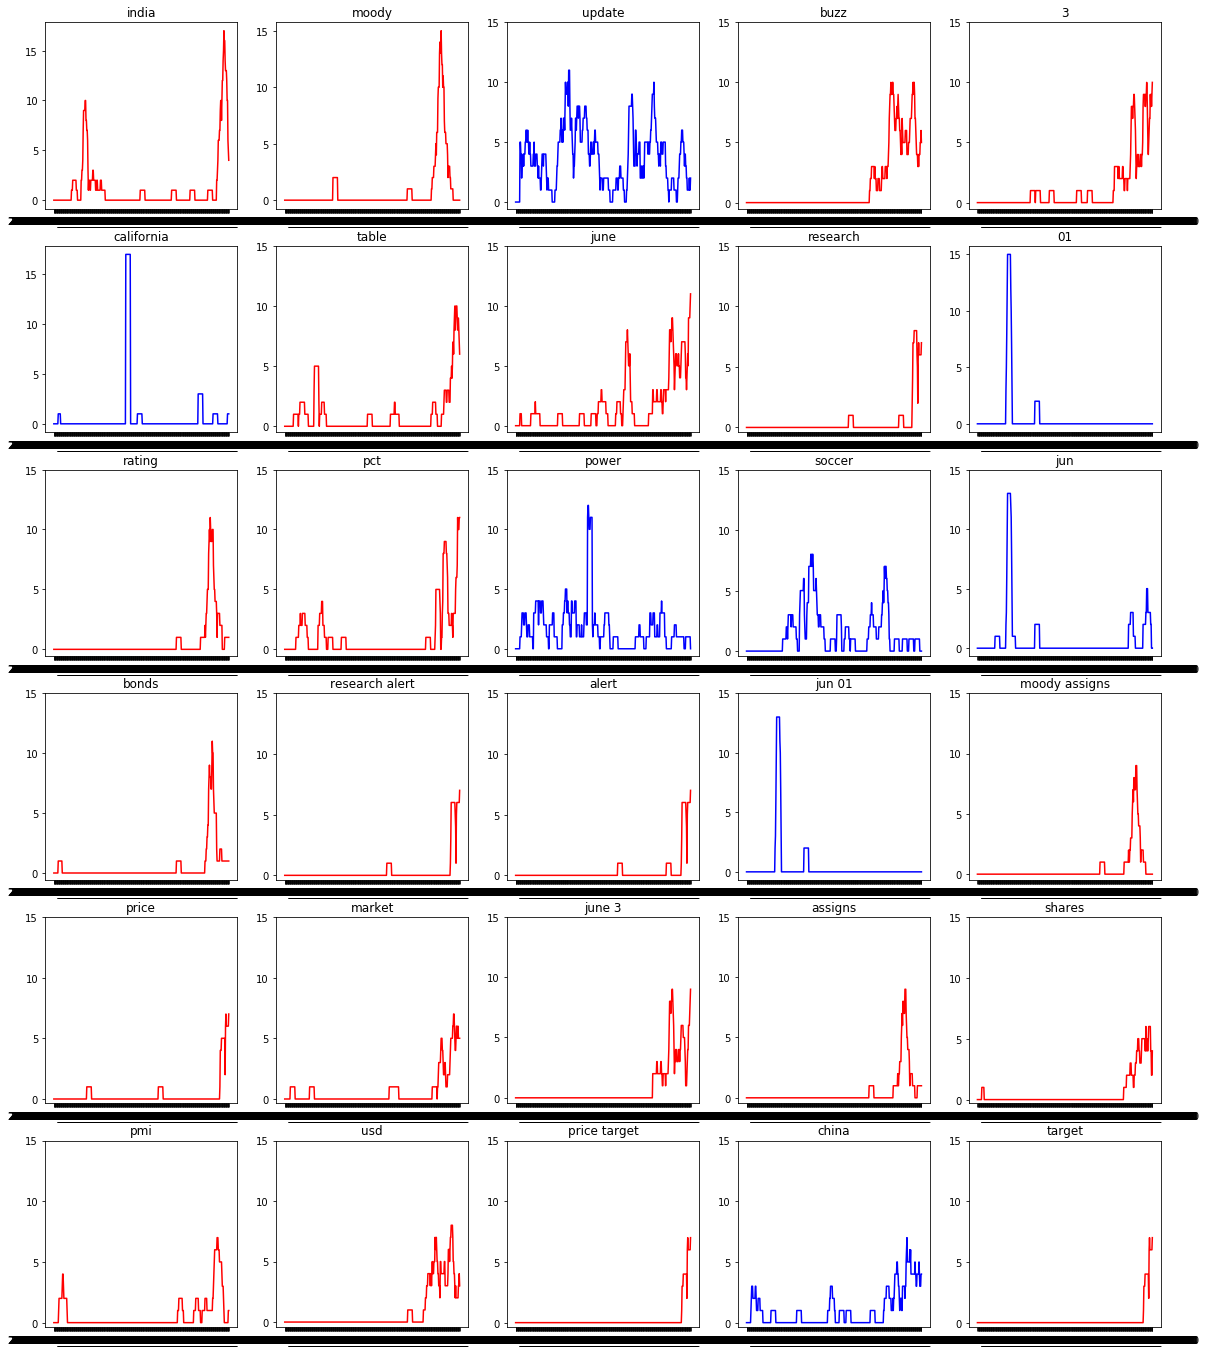

In [14]:
pp.make_plt(df_agg.rolling(12).sum().fillna(0),all_titles,trending_titles)

### Top 30 Highest Volume Words

12 out of the 30 top VOLUME words here seem to match the description of a trending topic.

The below image shows each of those 30 terms against time and highlighing the ones in RED as trending.
This approach is obviously subject to further discussion and what on those grids is onsidered a trend

In [34]:
# Load data from file and generate lists of 
top30_vol=pd.read_csv('./ground_truth/Top30_wrds.csv', index_col=0)
all_titles_vol=list(top30_vol.Topic)
trending_titles_vol=list(top30_vol[top30_vol.Label==1].Topic)

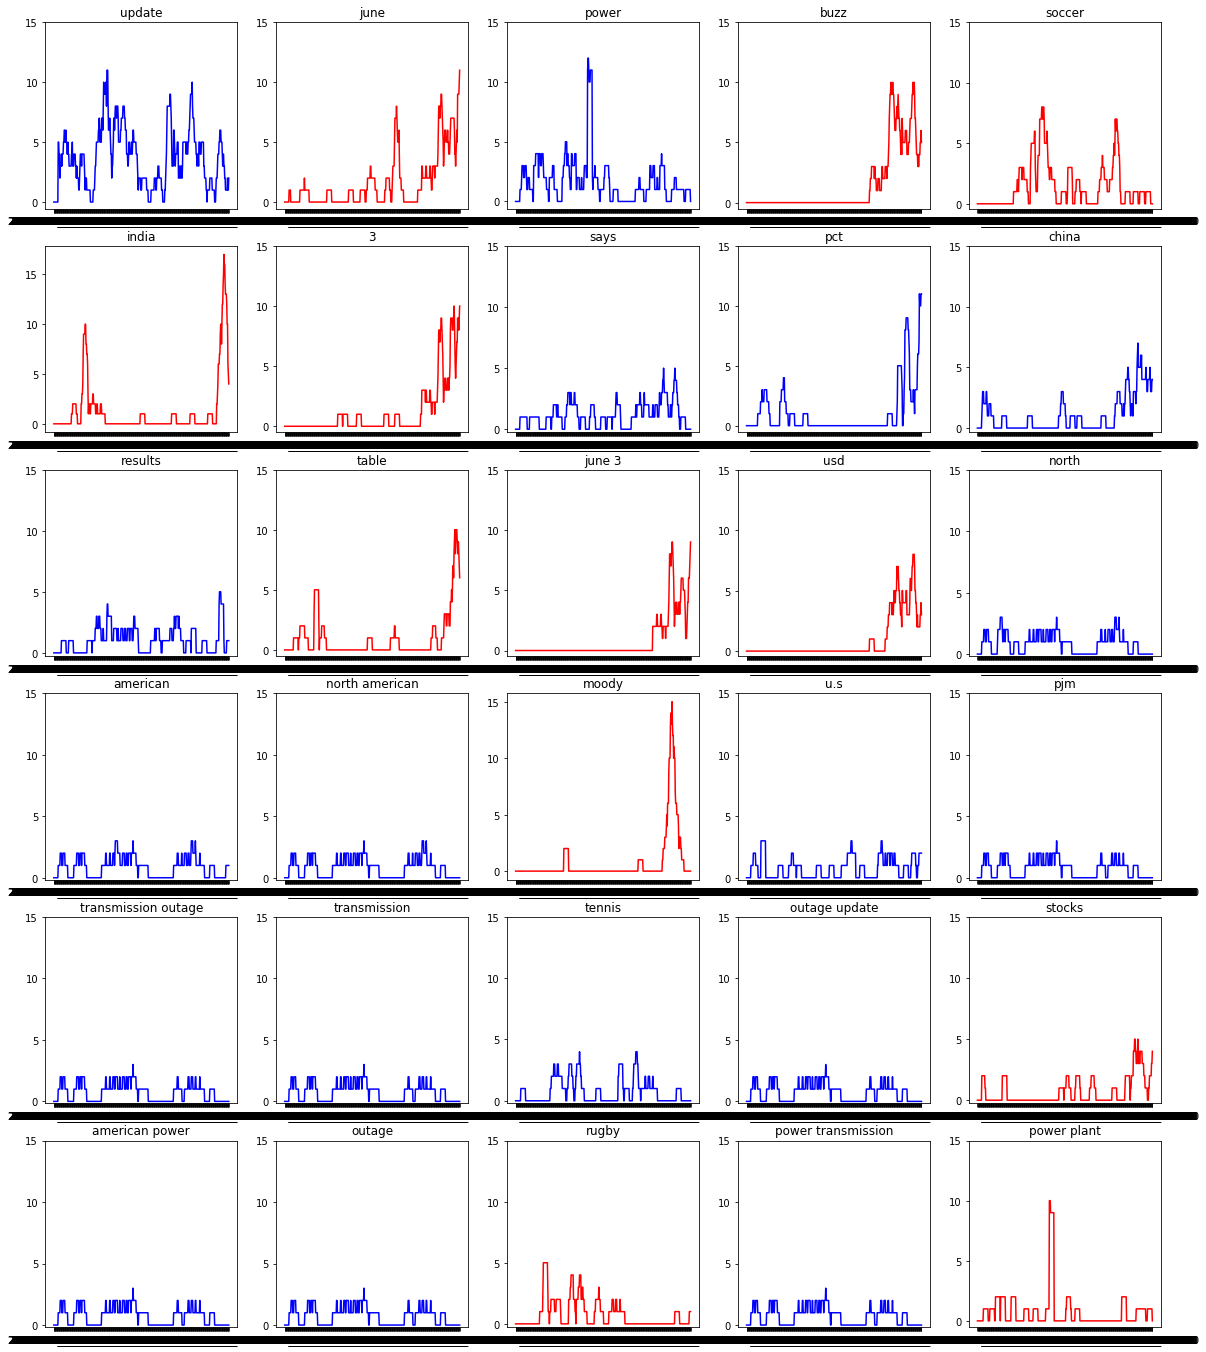

In [36]:
pp.make_plt(df_agg.rolling(12).sum().fillna(0),all_titles_vol,trending_titles_vol)

In [53]:
pipe_ttl=md.TrainPipe('HEADLINE_ALERT_TEXT','lda',ngram=2, min_df=5)
pipe_ttl.fit(df_unq_en,)

pipe_art=md.TrainPipe('ART_BODY_MERGED','lda',ngram=2, min_df=5)
pipe_art.fit(df_unq_en,)



In [60]:
_,df_agg=ev.pipe_transform(df_unq_en,pipe_ttl,time_interval=5)

In [69]:
all_titles_lda, trending_titles_lda=ev.get_ground_truths('./ground_truth/LDA30_tpcs.csv')

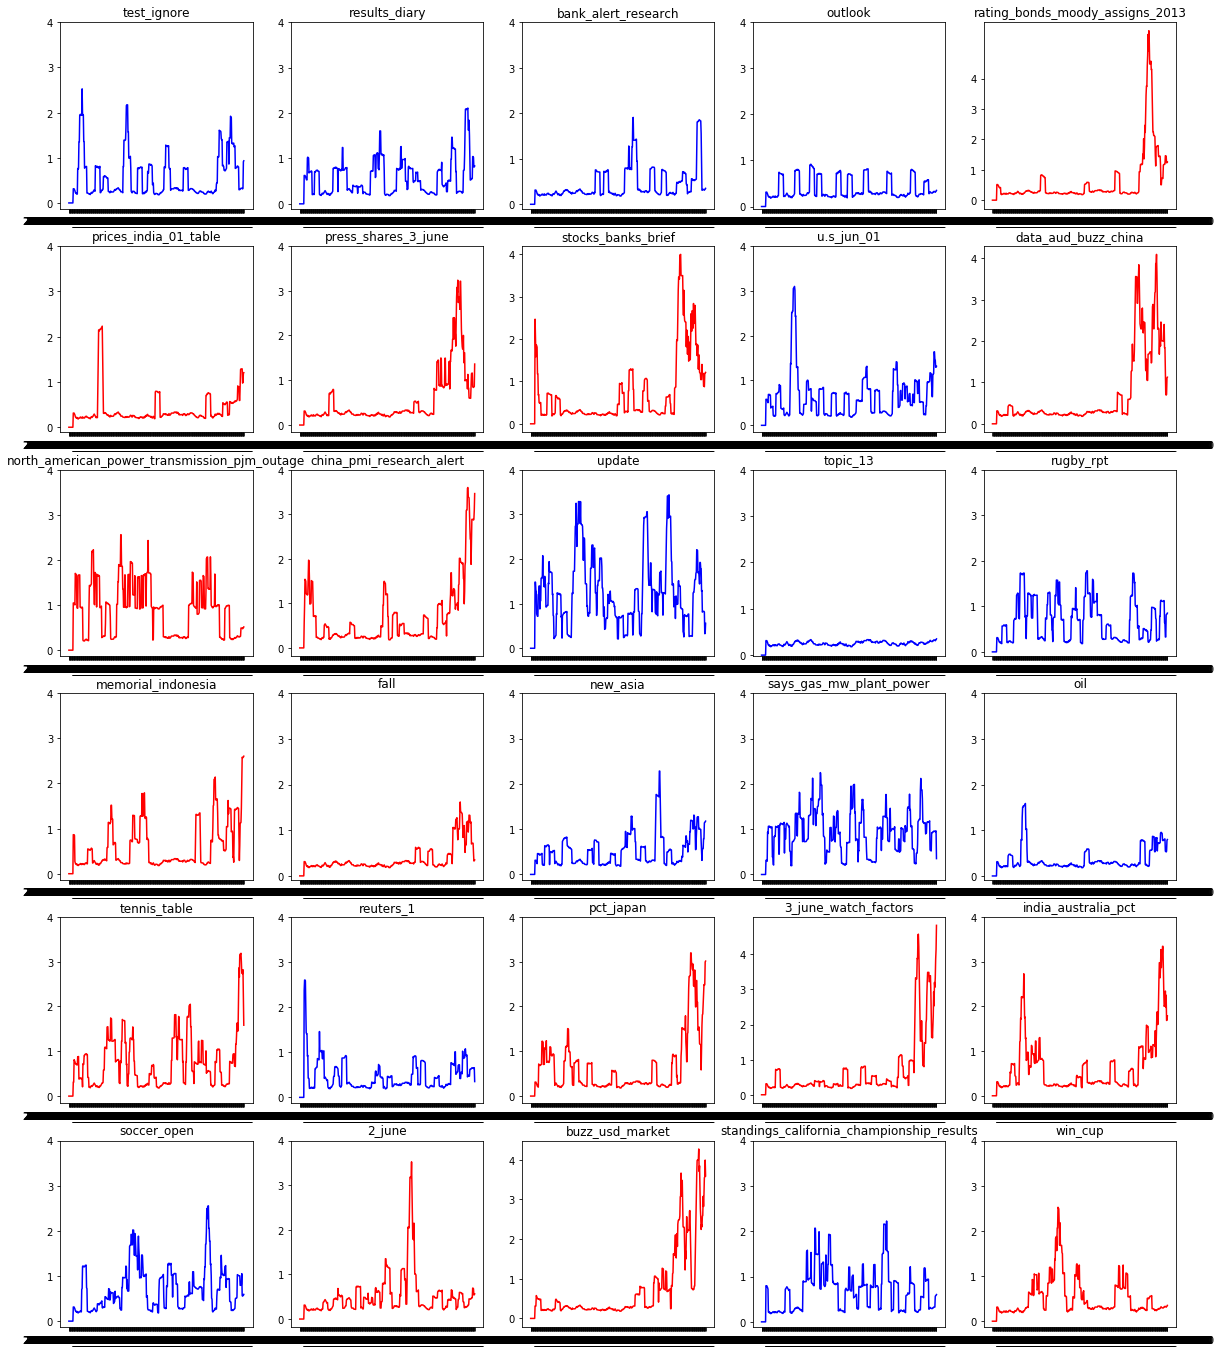

In [66]:
pp.make_plt(df_agg.rolling(12).sum().fillna(0),all_titles_lda,trending_titles_lda, chart_scale=[4,5])

In [306]:
df_pred_spk=pd.DataFrame(list(top50_spk.index), columns=['Topic'])
df_pred_spk['Label']=0
df_pred_spk['Label']=df_pred_spk.apply(lambda x: 1 if x['Topic'] in res_spk_cnt else 0, axis=1)

from sklearn.metrics import accuracy_score

accuracy_score(df_spk_true['Label'],df_pred_spk['Label'])



0.9